# LSTM for Forecasting
This notebook contains Python code for building an LSTM (Long Short Term Memory) Neural Network for time series data.    

### Business Challenge:
A customer wants to be able to understand the dynamics of a particular futures market.  Specifically, can the pricing history of specific group of agricultural sites be used to predict the future pricing movement of a separate, geographic location of similar agricultural distributors?  Here we use LSTM to demonstrate the utility of Neural Networks, however there are other options, such as Bayesian Time Series, ARIMA, Vector Auto-Regressive, and other algorithms that could be used to model the dynamics.  

In this particular case, there are multiple independent variables, beyond the simple "price" of the group of agg. distributors.  There are possible lags, time series structures, stochastic jumps / dips, as well as known periodic changes due to the idiosyncratic nature of this particular market that must be taken into consideration. 

The goal of the forecast model is to predict an out-of-sample forecast using a hold-out period which observes the lowest error rate possible.  In most cases we'll use the MAPE (mean absolute percentage error), however, the Mean Squared Error is also sometimes used. 

In [34]:
# load the relevant Python libraries
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Activation, Dropout, Dense
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import pmdarima as pmd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Load the dataset
df = pd.read_csv("cmv_all_data_onehot2017.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       882 non-null    object 
 1   week_num   882 non-null    int64  
 2   dow        882 non-null    object 
 3   River      882 non-null    float64
 4   Off_River  882 non-null    float64
 5   p1         882 non-null    int64  
 6   p2         882 non-null    int64  
 7   p3         882 non-null    int64  
 8   p4         882 non-null    int64  
 9   p5         882 non-null    int64  
 10  gs         882 non-null    int64  
 11  drop       882 non-null    int64  
 12  g1         882 non-null    float64
 13  g2         882 non-null    float64
 14  g3         882 non-null    float64
 15  g4         882 non-null    float64
 16  g5         882 non-null    float64
dtypes: float64(7), int64(8), object(2)
memory usage: 117.3+ KB


## Feature Engineering
The functions below will be used to create moving averages and a technical indicator, RSI (Relative Strength Index), which will then be entered in the LSTM as independent variables.

In [8]:
# Create a Moving Average 
def mov_avg(var, size):
    window_size = size

    numbers_series = pd.Series(var)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()

    ma = moving_averages.tolist()
    #without_nans = moving_averages_list[window_size - 1:]
    return ma

# Create Exponential Weighted Moving Average 
ewma = pd.Series.ewm

n = 14

def RSI(series,n):    
    delta = series.diff()
    u = delta * 0 
    d = u.copy()
    i_pos = delta > 0
    i_neg = delta < 0
    u[i_pos] = delta[i_pos]
    d[i_neg] = delta[i_neg]
    rs = ewma(u, span=n).mean() / ewma(d, span=n).mean()
    return 100 - 100 / (1 + rs)


### ARIMA Residuals 
We're going to run a typical ARIMA models on one of the key variables to remove the time-series structures (auto-correlation, seasonality, etc.) and use the residuals as a predictor.  In this way we have a more pure estimate of the effect of the variance of this variable without the time-related confounds. 

In [9]:
# Create ARIMA residuals to use as a predictor
x1 = df.Off_River.values
arima = pmd.auto_arima(df.River, exogenous=x1.reshape(-1,1), m=5, 
                       seasonal=True, error_action='ignore',
                       suppress_warnings=True,  
                        stepwise=True)
arima_resid = arima.resid()
df['arima'] = arima.resid()

### Create Lag Structures
We suspect that there are possible lag effects in the independent variables, which are important to capture when analyzing the effects.  For LSTM, we won't be able to interpret the specific effect of the covariate, but for other, traditional time series models, we could interpret the coefficient to make a determination of how such IVs impact future movement of the dependent variable. 

In [10]:
# Create Lagged variables - 1 day lags
df['R_l1'] = df.River.shift(1)
df['Or_l1'] = df.Off_River.shift(1)
df['Or_l2'] = df.Off_River.shift(2)
df['MA5'] = df['Off_River'].rolling(window=5).mean()

In [11]:
df['ma9'] = mov_avg(df['River'], 9)
df['ma21'] = mov_avg(df['River'], 21)
df['ema'] = df['River'].ewm(com=0.5).mean()
df['rsi'] = RSI(df.River, 14)
df['20sd'] = df['River'].rolling(window=20).std()

In [12]:
emafast = df['River'].ewm(span=12, adjust=False).mean()
emaslow = df['River'].ewm(span=26, adjust=False).mean()
#signal = df1['Close'].ewm(span=9, adjust=False).mean()
df['macd'] = emafast-emaslow

In [13]:
df['ma9_l1'] = df.ma9.shift(1)
df['ma21_l1'] = df.ma21.shift(1)
df['ema_l1'] = df.ema.shift(1)
df['rsi_l1'] = df.rsi.shift(1)
df['20sd_l1'] = df['20sd'].shift(1)
df['macd_l1'] = df.macd.shift(1)

In [14]:
# Show the new dataset
df.head()

,Date,week_num,dow,River,Off_River,p1,p2,p3,p4,p5,...,ema,rsi,20sd,macd,ma9_l1,ma21_l1,ema_l1,rsi_l1,20sd_l1,macd_l1
0,1/3/2017,52,Tuesday,-0.111695,-0.326429,1,0,0,0,0,...,-0.111695,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,1/4/2017,52,Wednesday,-0.111301,-0.324651,1,0,0,0,0,...,-0.111400,100.000000,NaN,0.000031,NaN,NaN,-0.111695,NaN,NaN,0.000000
2,1/5/2017,52,Thursday,-0.107047,-0.312766,1,0,0,0,0,...,-0.108386,100.000000,NaN,0.000395,NaN,NaN,-0.111400,100.000000,NaN,0.000031
3,1/6/2017,53,Friday,-0.117494,-0.315417,1,0,0,0,0,...,-0.114534,-61.617849,NaN,-0.000158,NaN,NaN,-0.108386,100.000000,NaN,0.000395
4,1/9/2017,53,Monday,-0.125394,-0.312292,1,0,0,0,0,...,-0.121804,-25.566964,NaN,-0.001220,NaN,NaN,-0.114534,-61.617849,NaN,-0.000158


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       882 non-null    object 
 1   week_num   882 non-null    int64  
 2   dow        882 non-null    object 
 3   River      882 non-null    float64
 4   Off_River  882 non-null    float64
 5   p1         882 non-null    int64  
 6   p2         882 non-null    int64  
 7   p3         882 non-null    int64  
 8   p4         882 non-null    int64  
 9   p5         882 non-null    int64  
 10  gs         882 non-null    int64  
 11  drop       882 non-null    int64  
 12  g1         882 non-null    float64
 13  g2         882 non-null    float64
 14  g3         882 non-null    float64
 15  g4         882 non-null    float64
 16  g5         882 non-null    float64
 17  R_l1       881 non-null    float64
 18  Or_l1      881 non-null    float64
 19  Or_l2      880 non-null    float64
 20  MA5       

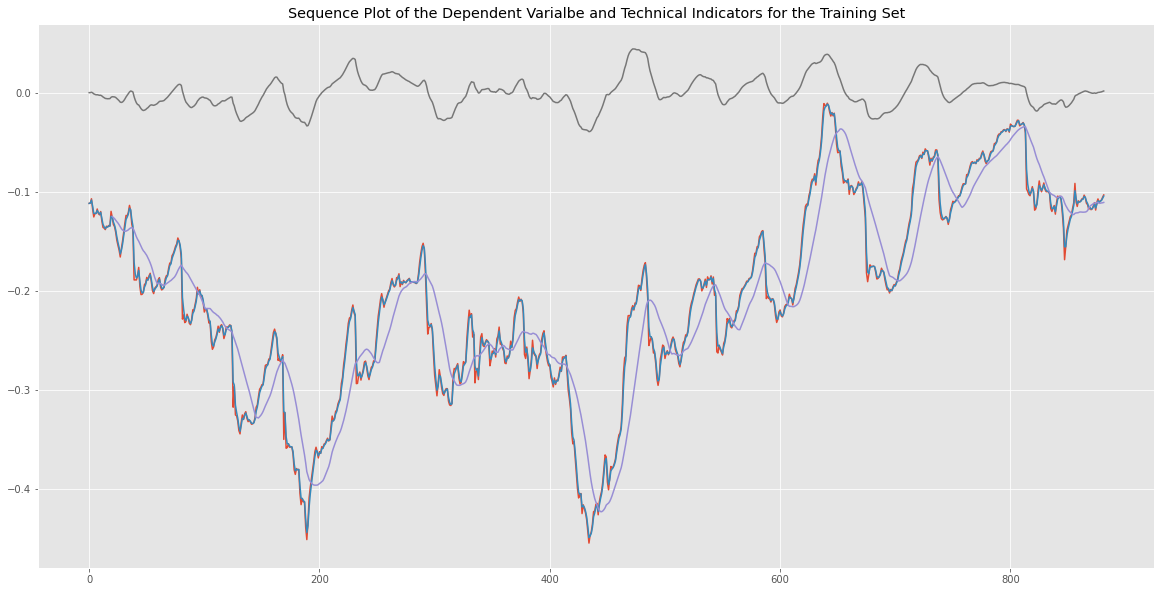

In [170]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
plt.plot(df.River)
plt.plot(df.ema)
plt.plot(df.ma21)
plt.plot(df.macd)
plt.title("Sequence Plot of the Dependent Varialbe and Technical Indicators for the Training Set")
plt.show()

# Setup the LSTM

In [187]:
input_feature= df.iloc[:,[3,4,17,18,19]].dropna().values
input_data = input_feature

In [188]:
input_data

array([[-0.10704698, -0.31276596, -0.11130121, -0.32465116, -0.32642857],
       [-0.11749409, -0.31541667, -0.10704698, -0.31276596, -0.32465116],
       [-0.12539352, -0.31229167, -0.11749409, -0.31541667, -0.31276596],
       ...,
       [-0.10842262, -0.20323529, -0.1090991 , -0.20742857, -0.21228571],
       [-0.10565476, -0.20142857, -0.10842262, -0.20323529, -0.20742857],
       [-0.10320588, -0.2       , -0.10565476, -0.20142857, -0.20323529]])

In [192]:
id_n = len(input_data)

In [189]:
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:5] = sc.fit_transform(input_feature[:,:])

In [193]:
lookback= 7  # number of days as a sliding window

test_size=int(.8 * id_n)
X=[]
y=[]
for i in range(id_n-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,0])

In [194]:
# Train / Test
n = 5
X, y= np.array(X), np.array(y)
X_test = X[test_size+lookback:]
X_train = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, n)
X_test = X_test.reshape(X_test.shape[0],lookback, n)
X_train = X_train.reshape(X_train.shape[0],lookback, n)
print(X.shape)
print(X_test.shape)
print(X_train.shape)

(872, 7, 5)
(161, 7, 5)
(711, 7, 5)


In [262]:
model = Sequential()
model.add(LSTM(units=300, return_sequences=True, activation='relu', input_shape=(X.shape[1],n)))
model.add(Dropout(0.1))
model.add(LSTM(units=150))
model.add(Dense(units=1))
ADAM=Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mae', metrics=['mape'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 7, 300)            367200    
_________________________________________________________________
dropout_37 (Dropout)         (None, 7, 300)            0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 150)               270600    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 151       
Total params: 637,951
Trainable params: 637,951
Non-trainable params: 0
_________________________________________________________________


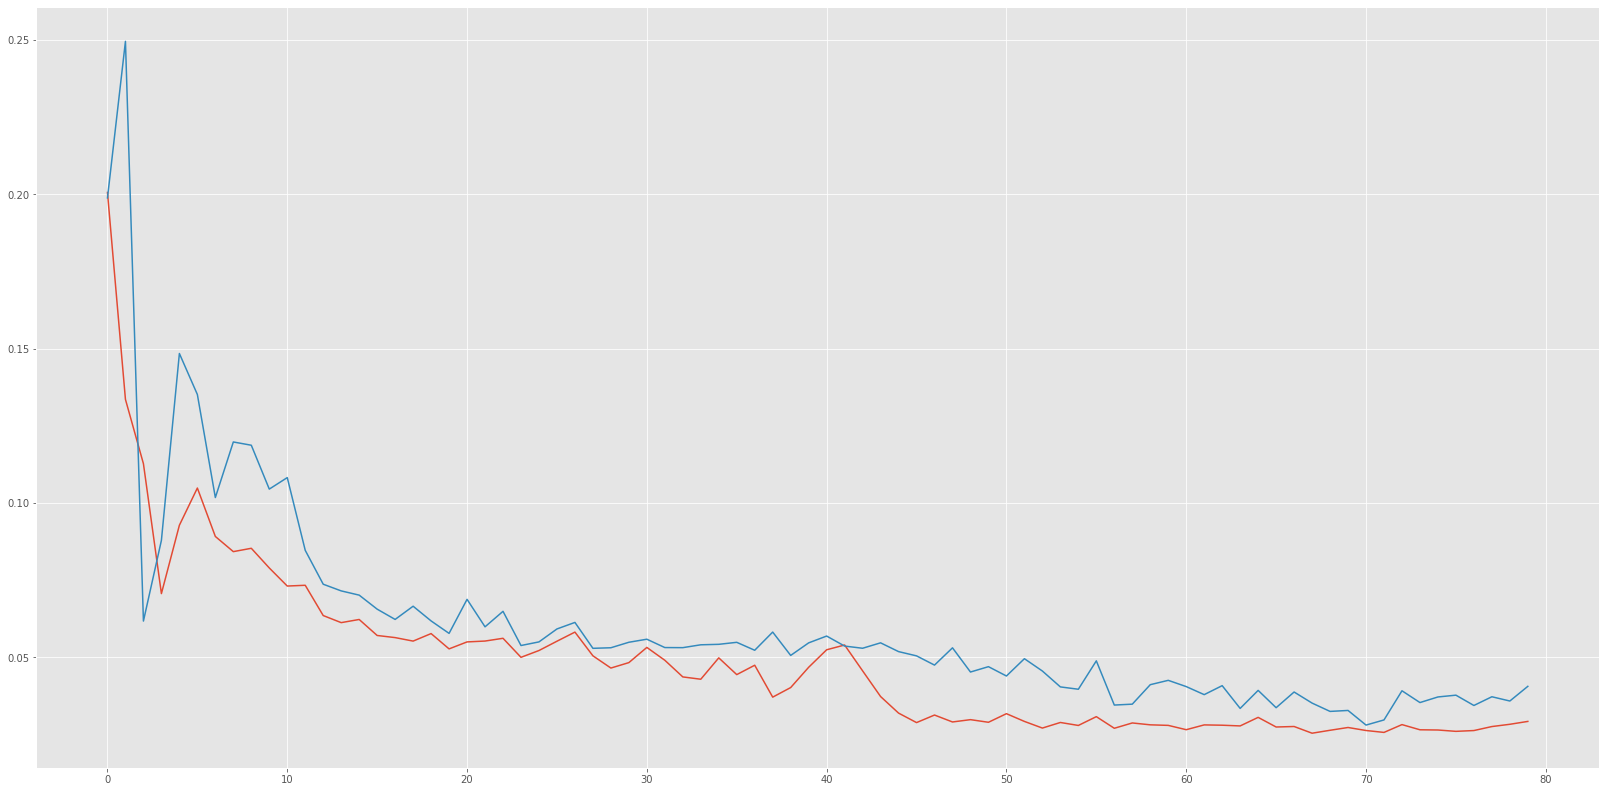

In [263]:
history = model.fit(X_train, y,epochs=80, batch_size=32, validation_split=0.2,verbose=0,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

c:\users\rcluk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


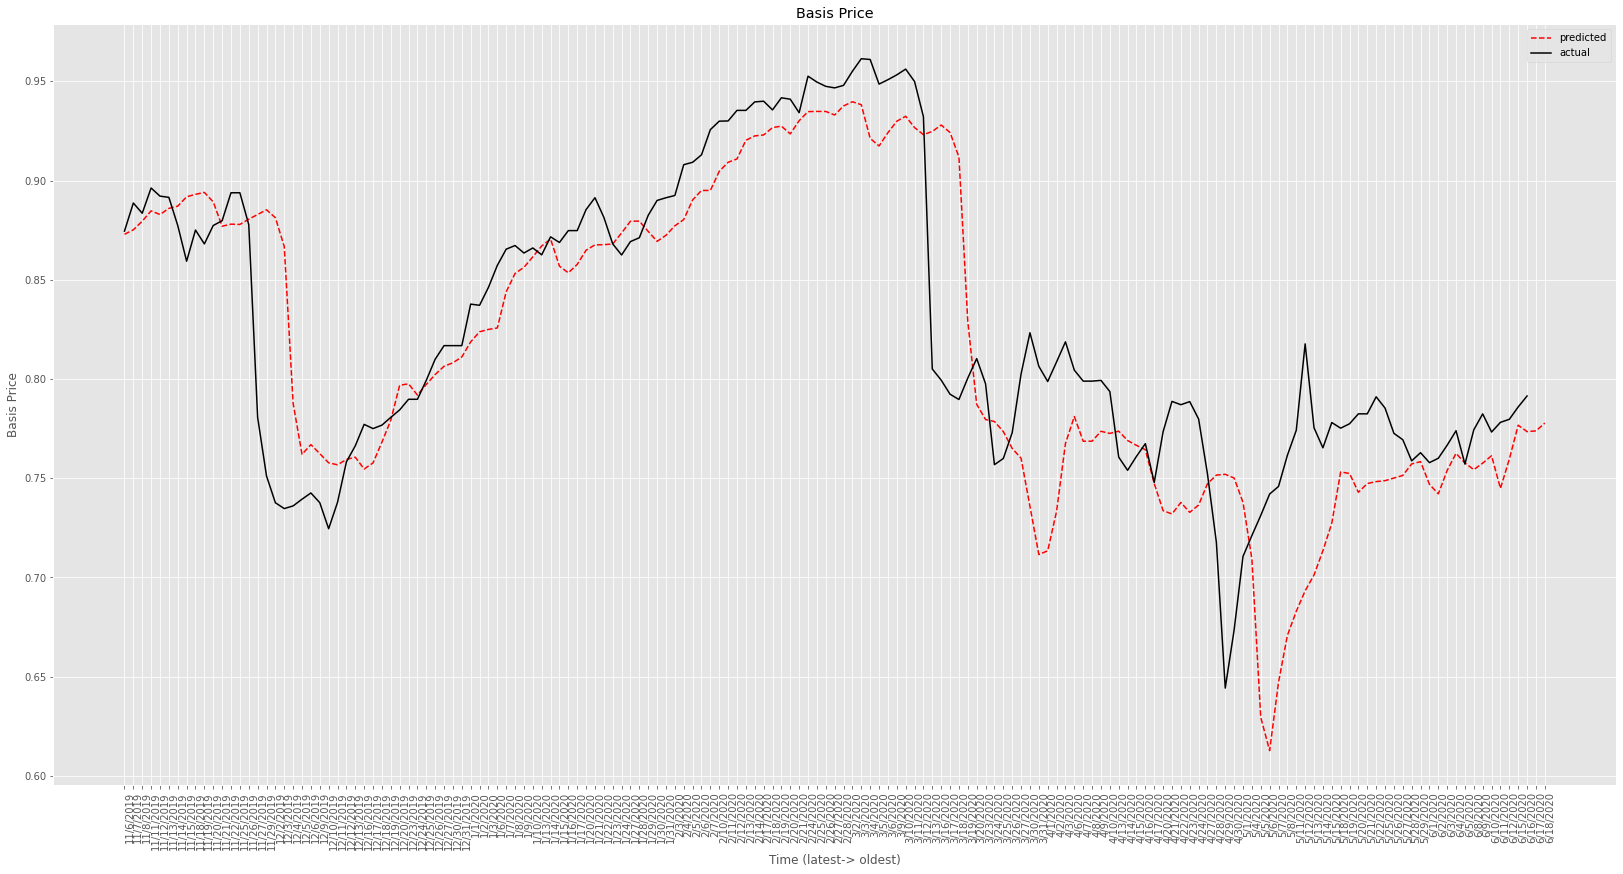

In [264]:
from sklearn import metrics
y_h = input_data[:,0]
predicted_value= model.predict(X_test)
#predicted_value
k = len(df) - len(predicted_value)
p = predicted_value
a = df.River[k:].reset_index(drop=True)

#print('Test RMSE: %.3f' % rmse)
z = pd.DataFrame(np.array(a), p.ravel()).reset_index()
z.columns = ['act', 'pred']

fig, ax = plt.subplots()
plt.rcParams['figure.figsize']=(28,14)
plt.style.use('ggplot')
ax.plot(df.Date[k:],predicted_value, color= 'red', label="predicted", linestyle="--")
ax.plot(y_h[k:], color='black', label="actual")
plt.title("Basis Price")
ax.legend()
plt.xlabel("Time (latest-> oldest)")
ax.set_xticklabels(df.Date[k:], rotation = 90, ha="right", rotation_mode="anchor")
plt.ylabel("Basis Price")
plt.show()

### MAPE for Past 30 days

In [265]:
from keras.losses import MAPE
loss = MAPE(y_h[-30:], predicted_value[-30:])
np.mean(loss)

4.004276